In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import time

import models
import flows

In [19]:
data = sio.loadmat("downstream.mat")
inputs_0 = data["inputs_0"]
targets_0 = data["targets_0"]
inputs_f = data["inputs_f"]
targets_f = data["targets_f"]
x_test = data["x"]
t_test = data["t"]
u_ref = data["u_ref"]

np.random.seed(1234)
noise_0 = 0.02
targets_0 = targets_0 + noise_0 * np.random.normal(size=targets_0.shape)
noise_f = 0.02
targets_f = targets_f + noise_f * np.random.normal(size=targets_f.shape)

#### MHPINN HMC

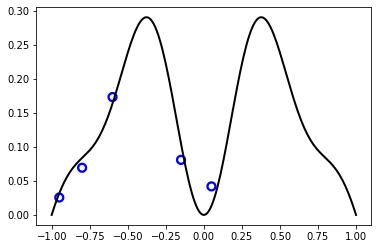

In [20]:
plt.scatter(inputs_0[:, 0:1], targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
plt.plot(x_test.flatten(), u_ref[0, :], color="black", linestyle="-", linewidth=2, label="reference")

In [21]:
mhpinn = models.MHPINN(num_tasks=2000, dim=50, ws=[1, 1], name="mhpinn")
mhpinn.restore()

permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))
nf = flows.MAF(
    dim=51,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf_mhpinn",
)
nf.restore()

In [22]:
import hmc

In [23]:
def pde_fn(xt, u):
    u_xt = tf.gradients(u, xt)[0]
    u_x, u_t = tf.split(u_xt, 2, axis=-1)
    u_xx = (tf.gradients(u_x, xt)[0])[:, 0:1]
    
    return u_t - (0.1 * u_xx + 0.1 * u * (1 - u))

In [24]:
model = hmc.PI_Bayesian(
    inputs_u=inputs_0,
    u=targets_0,
    inputs_f=inputs_f,
    f=targets_f,
    pde_fn=pde_fn, 
    meta=mhpinn, 
    flow=nf,
    noise_u=noise_0,
    noise_f=noise_f,
)

In [25]:
log_posterior = model.build_posterior()
hmc_kernel = hmc.AdaptiveHMC(
    target_log_prob_fn=log_posterior,
    init_state=model.initial_values,
    num_results=1000,
    num_burnin=1000,
    num_leapfrog_steps=50,
    step_size=0.1,
)

In [26]:
samples, results = hmc_kernel.run_chain()
print('Accepted rate: ', np.mean(results.inner_results.is_accepted.numpy()))

C:\Users\zouzo\anaconda3\envs\tf2\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Accepted rate:  0.638


In [35]:
heads = tf.transpose(samples[:, 0, :])

xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = mhpinn.call(
    tf.constant(inputs_test, tf.float32), heads
).numpy()
mu_u = np.mean(u_pred, axis=-1)
std_u = np.std(u_pred, axis=-1)
mu_u = mu_u.reshape([101, 201])
std_u = std_u.reshape([101, 201])

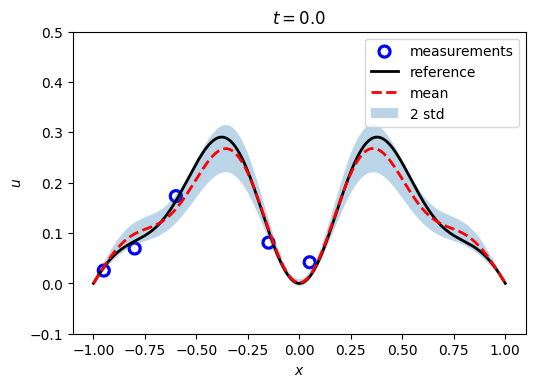

In [36]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
i = 0
ax.scatter(inputs_0[:, 0:1], targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_ref[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), mu_u[i, :], color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x_test.flatten(), (mu_u+2*std_u)[i, :], (mu_u-2*std_u)[i, :], alpha=0.3, label="2 std")
ax.legend(loc=1)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("u_0_uq.png")

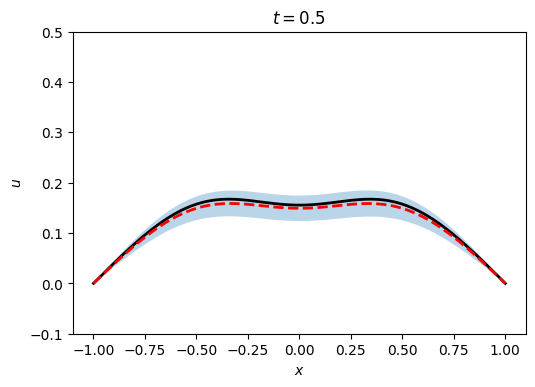

In [37]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
i = 50
ax.plot(x_test.flatten(), u_ref[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), mu_u[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
ax.fill_between(x_test.flatten(), (mu_u+2*std_u)[i, :], (mu_u-2*std_u)[i, :], alpha=0.3, label="2 std")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("u_1_uq.png")

In [42]:
sio.savemat(
    "hmc.mat",
    {
        "inputs_0": inputs_0,
        "targets_0": targets_0,
        "inputs_f": inputs_f,
        "targets_f": targets_f,
        "x": x_test,
        "t": t_test,
        "u_ref": u_ref,
        "u_mu": mu_u, "u_std": std_u,
    }
)